In [1]:
import os
import json
import math
import pandas as pd
from collections import Counter
from draw_utils import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_tiles_info(results, TARGET_CELLTYPE):
    tiles_list = []
    cell_counts = dict(zip(TARGET_CELLTYPE, [0]*len(TARGET_CELLTYPE)))

    for t in results.get("cell_masks", []):
        matched_types = set()   # 이 타일에서 발견된 타입(중복 제거)
        hit_count = 0           # 매칭된 마스크 총 개수(원하면 유지)

        for m in t.get("masks", []):
            ct = m.get("cell_type")
            # 대상 타입 중 하나라도 부분 일치하면 기록
            if ct not in TARGET_CELLTYPE:
                continue
            cell_counts[ct] +=1
            
            matched = False
            for target in TARGET_CELLTYPE:
                if target in ct:
                    matched_types.add(target)
                    matched = True
            if matched:
                hit_count += 1

        if matched_types:
            tiles_list.append({
                "x": t["x"], "y": t["y"], "level": t["level"],
                "width": t["width"], "height": t["height"],
                "count": hit_count,                     # 매칭된 마스크 수
                "types": sorted(matched_types)         # ✅ 중복 없이 1회씩만
            })
    tiles_sorted = sorted(   tiles_list,    key=lambda x: x["count"],    reverse=True)
    print(f"총 타일 수: {len(tiles_sorted)}")
    # for r in tiles_sorted[:3]:
    #     print(r)
    return tiles_sorted, cell_counts

In [3]:
INFERENCE_IMAGE_SIZE = 588
MPP = 0.25

output_dir = '/home/sjhong/segmentation/histoplus/output/KBSMC_HEATMAP_test/'
os.makedirs(output_dir, exist_ok = True)

df = pd.read_csv("/home/sjhong/document/sampling_test.csv")
priority = df.iloc[[0,36,37,65],1].tolist()
last = df.loc[~df.index.isin([0,36,37,65]), df.columns[1]].tolist()
sample_names = priority + last

sample_list = [f'/home/nas2_fast/Data/Pathology_project/KBSMC/wsi/{x}.svs' for x in sample_names]
print(len(sample_list))

66


In [4]:
new_target_cells = ['Apoptotic Body',
 'Cancer cell',
 'Epithelial',
 'Fibroblasts',
 'Lymphocytes',
 'Macrophages',
 'Neutrophils']

## 자동화

In [5]:
# ---- 핵심: 테이블 생성 ----
def build_count_table(sample_list, output_dir, INFERENCE_IMAGE_SIZE, target_cells, get_tiles_info, ref_df = None):
    rows, idx = [], []
    cols = list(target_cells) + ['Total_tiles']  # 컬럼 고정

    for wsi_path in sample_list:
        sid = os.path.splitext(os.path.basename(wsi_path))[0]
        
        if ref_df is not None and sid in ref_df.index:
            continue
        
        jpath = f"{output_dir}/seg_{sid}_{INFERENCE_IMAGE_SIZE}.json"
        if not os.path.exists(jpath):
            # 없으면 패스 (필요시 로그)
            continue
        try:
            with open(jpath, "r", encoding="utf-8") as f:
                results = json.load(f, parse_float=float)
        except:
            continue
        
        tiles_sorted, cell_counts = get_tiles_info(results, target_cells)

        total = int(len(tiles_sorted))
        # side-effect 방지: 복사해서 사용
        row = {k: int(cell_counts.get(k, 0)) for k in target_cells}
        row['Total_tiles'] = total
        rows.append(row)
        idx.append(sid)

    # counts DF (누락 0 채움 + 컬럼 순서 고정)
    df_counts = pd.DataFrame(rows, index=idx).reindex(columns=cols).fillna(0).astype(int)
    if ref_df is not None:
        df_counts = pd.concat([ref_df, df_counts])
    return df_counts

In [6]:
df_counts = build_count_table(sample_list, output_dir, INFERENCE_IMAGE_SIZE, COLOR_MAP.keys(), get_tiles_info)

총 타일 수: 4153
총 타일 수: 5103
총 타일 수: 9204
총 타일 수: 8000
총 타일 수: 8975
총 타일 수: 9953
총 타일 수: 3196
총 타일 수: 5210
총 타일 수: 11002
총 타일 수: 4920
총 타일 수: 3857
총 타일 수: 6547
총 타일 수: 4842
총 타일 수: 8736
총 타일 수: 5404
총 타일 수: 7654
총 타일 수: 6782
총 타일 수: 5161
총 타일 수: 3297
총 타일 수: 15581
총 타일 수: 1585


### 더 할 경우

In [18]:
df_counts_total = build_count_table(sample_list, output_dir, INFERENCE_IMAGE_SIZE, COLOR_MAP.keys(), get_tiles_info, ref_df = df_counts)
df_counts_total.shape

총 타일 수: 6142
총 타일 수: 8131
총 타일 수: 5712
총 타일 수: 7944
총 타일 수: 9980
총 타일 수: 13338


(27, 15)

In [ ]:
### df_counts df_counts 잘 바꿔가면서 봐야함

In [19]:
order = {v: i for i, v in enumerate(df["Patient_id"])}
sorted_index = sorted(df_counts_total.index, key=lambda x: order[x])
df_filtered = df_counts_total.loc[sorted_index, new_target_cells]
df_filtered

,Apoptotic Body,Cancer cell,Epithelial,Fibroblasts,Lymphocytes,Macrophages,Neutrophils
1-007_05,2996,142126,859,57300,18156,3366,297
1_160_19,1443,143239,2834,137489,21915,6984,502
1_115_17,2770,443812,7512,34215,11113,5770,663
1_120_17,2402,204112,510,9953,2033,1402,311
1-049_10,6515,182779,1363,70648,39188,9013,796
1-015_07,4491,204059,5340,214680,157780,31933,914
1-046_10,4660,192485,3545,51989,43946,6050,398
1-008_06,2365,83940,1017,59991,15808,1767,654
1-066_11,6883,147318,1353,98388,40919,3512,766
1_125_17,4978,194632,3667,52565,14613,3453,677


In [9]:
def minmax_scale_columns(df):
    # column-wise: 각 cell type을 샘플들 사이에서 0~1로
    mn = df.min(axis=0)
    mx = df.max(axis=0)
    scaled = (df - mn) / (mx - mn)
    return scaled.replace([np.inf, -np.inf], 0.0).fillna(0.0)

def l1_rows(df):
    row_sum = df.sum(axis=1).replace(0, np.nan)
    out = df.div(row_sum, axis=0)
    return out.fillna(0.0)

def zscore_columns(df, ddof=1):
    mu  = df.mean(axis=0)                # 컬럼별 평균
    std = df.std(axis=0, ddof=ddof)      # 컬럼별 표준편차
    z = (df - mu) / std
    # 표준편차 0인 컬럼 처리(모두 같은 값일 때)
    return z.replace([np.inf, -np.inf], 0.0).fillna(0.0)

In [10]:
title="Cell-type ratios across samples"

In [11]:
df_ratio = df_counts.iloc[:, :-1].div(df_counts.iloc[:, -1], axis=0)
sorted_index = sorted(df_ratio.index, key=lambda x: order[x])
df_filtered = df_ratio.loc[sorted_index, new_target_cells]
df_scaled = zscore_columns(df_filtered)  # .shape 질문의 테이블
df_scaled.shape

(21, 7)

In [20]:
sorted_index = sorted(df_counts_total.index, key=lambda x: order[x])
df_filtered = df_counts_total.loc[sorted_index, new_target_cells]
df_scaled = zscore_columns(df_filtered)  # df_ratio가 질문의 테이블
df_scaled.shape

(27, 7)

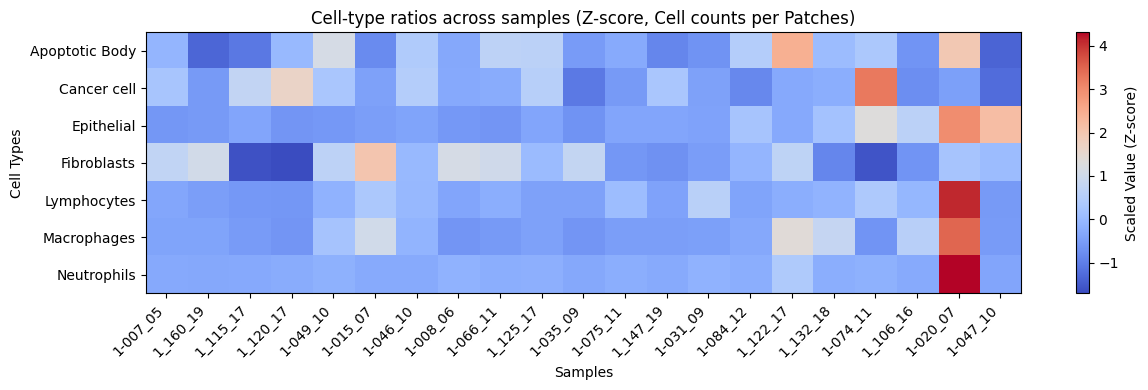

In [12]:
mat = df_scaled.copy()

plt.figure(figsize=(max(8, mat.shape[0]*0.6), max(4, mat.shape[1]*0.35)))

# 전치(transpose)해서 가로=mat.index, 세로=mat.columns
plt.imshow(mat.T.values, aspect='auto', cmap='coolwarm')

plt.colorbar(label='Scaled Value (Z-score)')
plt.xticks(np.arange(mat.shape[0]), mat.index, rotation=45, ha='right')
plt.yticks(np.arange(mat.shape[1]), mat.columns)
plt.title(title + (" (Z-score, Cell counts per Patches)" if df_scaled is not None else ""))
plt.xlabel("Samples")
plt.ylabel("Cell Types")

plt.tight_layout()
plt.show()


### 넘기려고함

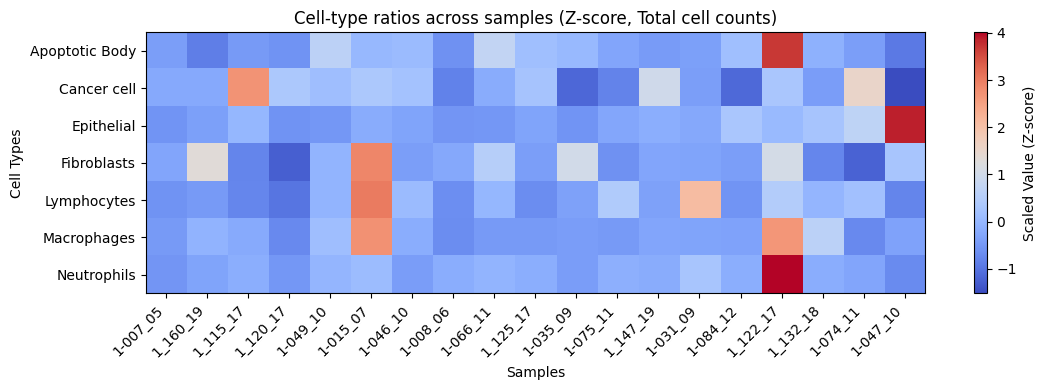

In [93]:
mat = df_scaled.copy()

plt.figure(figsize=(max(8, mat.shape[0]*0.6), max(4, mat.shape[1]*0.35)))

# 전치(transpose)해서 가로=mat.index, 세로=mat.columns
plt.imshow(mat.T.values, aspect='auto', cmap='coolwarm')

plt.colorbar(label='Scaled Value (Z-score)')
plt.xticks(np.arange(mat.shape[0]), mat.index, rotation=45, ha='right')
plt.yticks(np.arange(mat.shape[1]), mat.columns)
plt.title(title + (" (Z-score, Total cell counts)" if df_scaled is not None else ""))
plt.xlabel("Samples")
plt.ylabel("Cell Types")

plt.tight_layout()
plt.show()


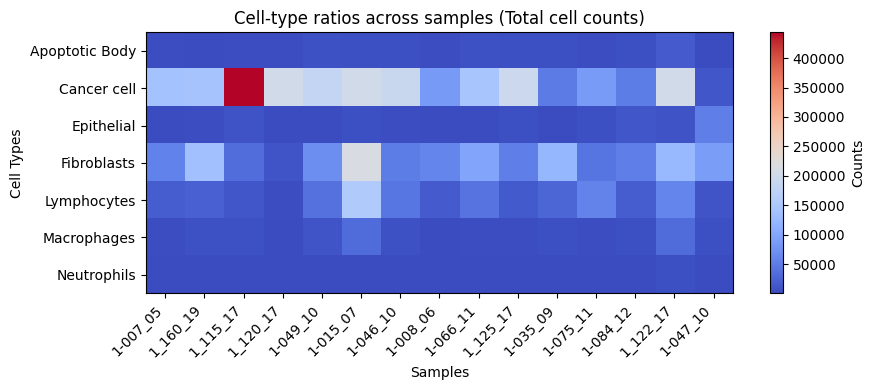

In [ ]:
mat = df_filtered.copy()

plt.figure(figsize=(max(8, mat.shape[0]*0.6), max(4, mat.shape[1]*0.35)))

# 전치(transpose)해서 가로=mat.index, 세로=mat.columns
plt.imshow(mat.T.values, aspect='auto', cmap='coolwarm')

plt.colorbar(label='Counts')
plt.xticks(np.arange(mat.shape[0]), mat.index, rotation=45, ha='right')
plt.yticks(np.arange(mat.shape[1]), mat.columns)
plt.title(title + (" (Total cell counts)" if df_scaled is not None else ""))
plt.xlabel("Samples")
plt.ylabel("Cell Types")

plt.tight_layout()
plt.show()


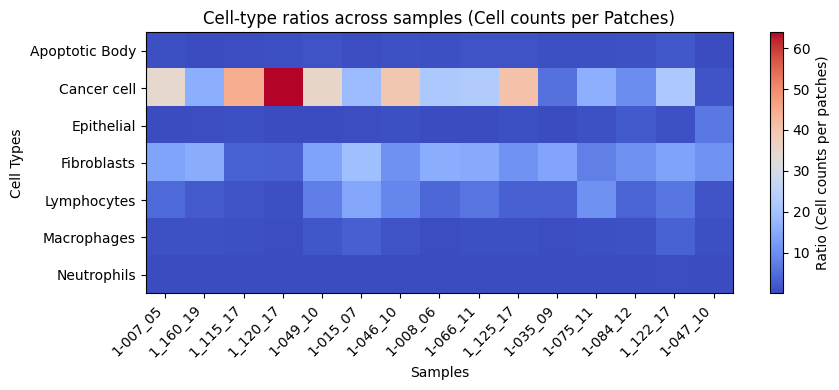

In [61]:
mat = df_filtered.copy()

plt.figure(figsize=(max(8, mat.shape[0]*0.6), max(4, mat.shape[1]*0.35)))

# 전치(transpose)해서 가로=mat.index, 세로=mat.columns
plt.imshow(mat.T.values, aspect='auto', cmap='coolwarm')

plt.colorbar(label='Ratio (Cell counts per patches)')
plt.xticks(np.arange(mat.shape[0]), mat.index, rotation=45, ha='right')
plt.yticks(np.arange(mat.shape[1]), mat.columns)
plt.title(title + (" (Cell counts per Patches)" if df_scaled is not None else ""))
plt.xlabel("Samples")
plt.ylabel("Cell Types")

plt.tight_layout()
plt.show()


15


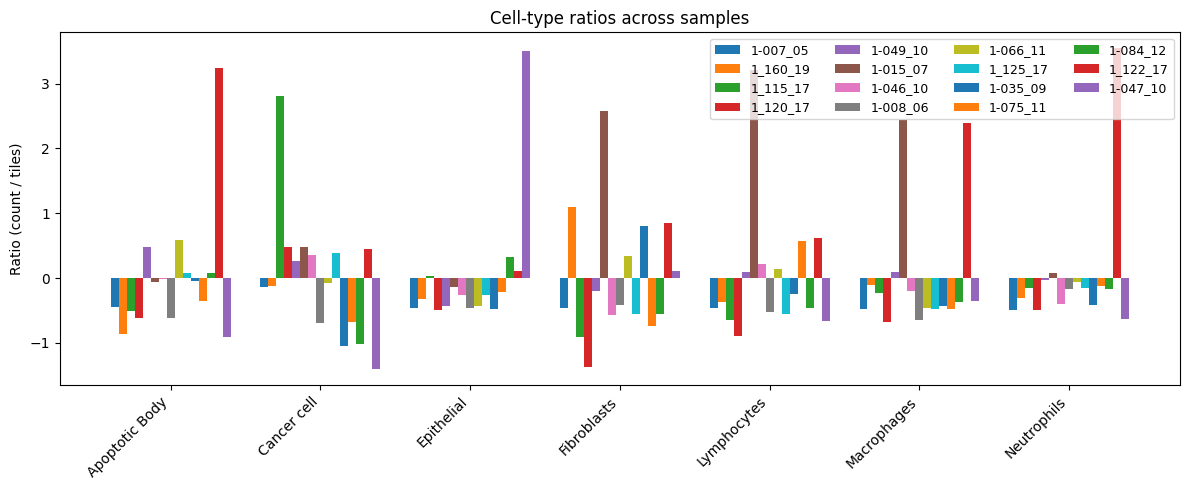

In [25]:
keys = list(df_scaled.columns)
x = np.arange(len(keys))
n_samples = df_scaled.shape[0]
print(n_samples)
width = min(0.8 / max(n_samples,1), 0.2)
offsets = (np.arange(n_samples) - (n_samples - 1)/2.0) * width

plt.figure(figsize=(max(12, len(keys)*0.8), 5))
for i, (sid, row) in enumerate(df_scaled.iterrows()):
    plt.bar(x + offsets[i], row.values, width, label=sid)
plt.xticks(x, keys, rotation=45, ha='right')
plt.ylabel('Ratio (count / tiles)')
plt.title(title)
plt.legend(ncol=min(n_samples, 4), fontsize=9)
plt.tight_layout()
plt.show()

### 기존 heatmap과의 연관성

In [13]:
hdf = pd.read_csv('/home/sjhong/document/sampling_test_heatmap.csv')
hdf

,Sample_id,Patient_id,Image+Proteome,Image score,Proteome score,EMT score,Coagulation score,UPR score,Recurrence,HALLMARK_G2M_CHECKPOINT,...,HALLMARK_OXIDATIVE_PHOSPHORYLATION,KEGG_OXIDATIVE_PHOSPHORYLATION,WP_OXIDATIVE_STRESS_RESPONSE,HALLMARK_ADIPOGENESIS,GOBP_POSITIVE_REGULATION_OF_CELL_KILLING,SMID_BREAST_CANCER_NORMAL_LIKE_UP,TURASHVILI_BREAST_DUCTAL_CARCINOMA_VS_DUCTAL_NORMAL_DN,LANDIS_BREAST_CANCER_PROGRESSION_DN,SARRIO_EPITHELIAL_MESENCHYMAL_TRANSITION_DN,GOCC_TERTIARY_GRANULE_LUMEN
0,TNBC00705PTfp01,1-007_05,2.790678,3.169907,-0.379228,-2.634818,1.731791,0.208831,0,0.462884,...,-1.163482,-1.210302,-2.187472,-1.657298,-0.245273,-0.919762,-0.316555,-1.424021,-1.728060,-0.774244
1,TNBC16019PTfp01,1_160_19,2.382394,2.611123,-0.228729,0.255040,-0.930376,0.645732,0,-1.548155,...,0.947077,1.169017,1.050490,0.487996,-0.621730,-0.268976,-0.309421,0.055175,0.789262,0.063051
2,TNBC11517PTfp01,1_115_17,1.367165,2.506106,-1.138941,-0.191679,-1.046467,-1.171178,0,0.455218,...,-0.642127,-1.058918,-1.863647,-1.050705,-2.041734,-2.069041,-1.547455,-1.168321,-1.465333,-1.175955
3,TNBC05410PTfp01,1-054_10,3.903395,2.422881,1.480513,0.707241,1.207079,1.083030,0,-0.083216,...,-0.499878,-0.055115,-0.981222,-0.822235,-1.614699,-0.673654,0.593063,0.111215,-0.611562,-0.663218
4,TNBC12017PTfp01,1_120_17,1.904779,2.065454,-0.160675,0.037995,-0.310605,0.059435,1,-0.078011,...,0.369091,0.407979,-0.977746,-0.892052,-1.713739,-1.431715,-0.192147,-0.655098,-0.885736,-1.175267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,TNBC10616PTfp01,1_106_16,-1.745458,-1.039920,-0.705538,0.044403,-0.642140,-1.012414,0,0.002330,...,-0.511111,-0.298960,0.073998,-0.644137,1.397467,-0.145020,-0.381082,-1.141050,-0.499449,-0.475455
62,TNBC06511PTfp01,1-065_11,-0.861606,-1.049664,0.188058,-0.001050,-0.426977,1.433228,0,-1.614242,...,2.793181,2.509300,1.462433,1.941403,0.712148,1.327121,0.942749,1.047969,1.573813,2.363101
63,TNBC02007PTfp01,1-020_07,-1.124982,-1.069296,-0.055686,0.520815,-0.128548,-0.813984,0,0.458321,...,0.768269,0.634662,0.212867,1.238705,0.599886,1.358974,0.765269,0.364611,0.806691,0.445398
64,TNBC00906PTfp01,1-009_06,-0.200501,-1.115272,0.914771,-0.116908,0.776219,1.602249,0,-2.902559,...,3.034882,2.506718,0.590482,1.278903,-1.843907,0.189790,2.213074,1.064189,0.328385,0.892176


In [21]:
hdf_filtered = hdf[hdf['Patient_id'].isin(df_scaled.index)]
hdf_filtered.shape

(27, 32)

In [22]:
heatmap = pd.merge(
    hdf_filtered,
    df_scaled.reset_index(),
    left_on='Patient_id',   # 왼쪽 DataFrame에서의 기준 컬럼
    right_on='index',       # 오른쪽 DataFrame에서의 기준 컬럼
    how='left'
)
heatmap['Recurrence'] = heatmap['Recurrence'].apply(lambda x: -3 if x == 0 else 3) 

In [25]:
heatmap[heatmap['Recurrence'] == 3]

,Sample_id,Patient_id,Image+Proteome,Image score,Proteome score,EMT score,Coagulation score,UPR score,Recurrence,HALLMARK_G2M_CHECKPOINT,...,SARRIO_EPITHELIAL_MESENCHYMAL_TRANSITION_DN,GOCC_TERTIARY_GRANULE_LUMEN,index,Apoptotic Body,Cancer cell,Epithelial,Fibroblasts,Lymphocytes,Macrophages,Neutrophils
3,TNBC12017PTfp01,1_120_17,1.904779,2.065454,-0.160675,0.037995,-0.310605,0.059435,3,-0.078011,...,-0.885736,-1.175267,1_120_17,-0.346243,0.552863,-0.610404,-1.440277,-1.144421,-0.859060,-0.346686
4,TNBC04810PTfp02,1-049_10,3.612166,2.057880,1.554286,1.017663,0.850761,1.442930,3,0.873599,...,-0.646673,-0.201188,1-049_10,-0.060028,0.322790,-0.544094,-0.058848,-0.224633,-0.043117,-0.232343
14,TNBC04810PTfp01,1-048_10,1.735228,1.045959,0.689269,0.435105,0.491574,0.469469,3,1.068081,...,0.493653,-0.336907,1-048_10,0.317833,0.227830,-0.526447,-0.368113,-0.372051,0.059372,-0.252854
15,TNBC03909PTfp01,1-039_09,2.185248,1.039316,1.145933,2.088492,0.319506,-0.704017,3,0.674236,...,-0.017019,0.207893,1-039_09,-0.294470,-0.315553,-0.207957,0.158284,-0.813738,-0.654404,-0.282795
16,TNBC04810PTfp03,1-050_10,1.765792,0.974173,0.791620,-0.032925,1.249415,0.169813,3,0.876162,...,0.350454,-0.116083,1-050_10,0.007680,-0.033433,-0.537020,0.325344,0.901022,-0.156433,-0.095604
17,TNBC08412PTfp01,1-084_12,-0.234408,0.142632,-0.377040,0.829979,-0.904862,-0.878781,3,1.467154,...,-0.373723,0.073985,1-084_12,-0.166985,-1.101142,0.239423,-0.472833,-0.734743,-0.526507,-0.264406
19,TNBC06911PTfp01,1-069_11,-1.301507,-0.946261,-0.355245,0.245300,-0.313765,-0.904921,3,0.241694,...,0.765380,1.866155,1-069_11,4.866927,-0.935563,-0.526059,-0.264258,-0.161061,1.065927,4.832906


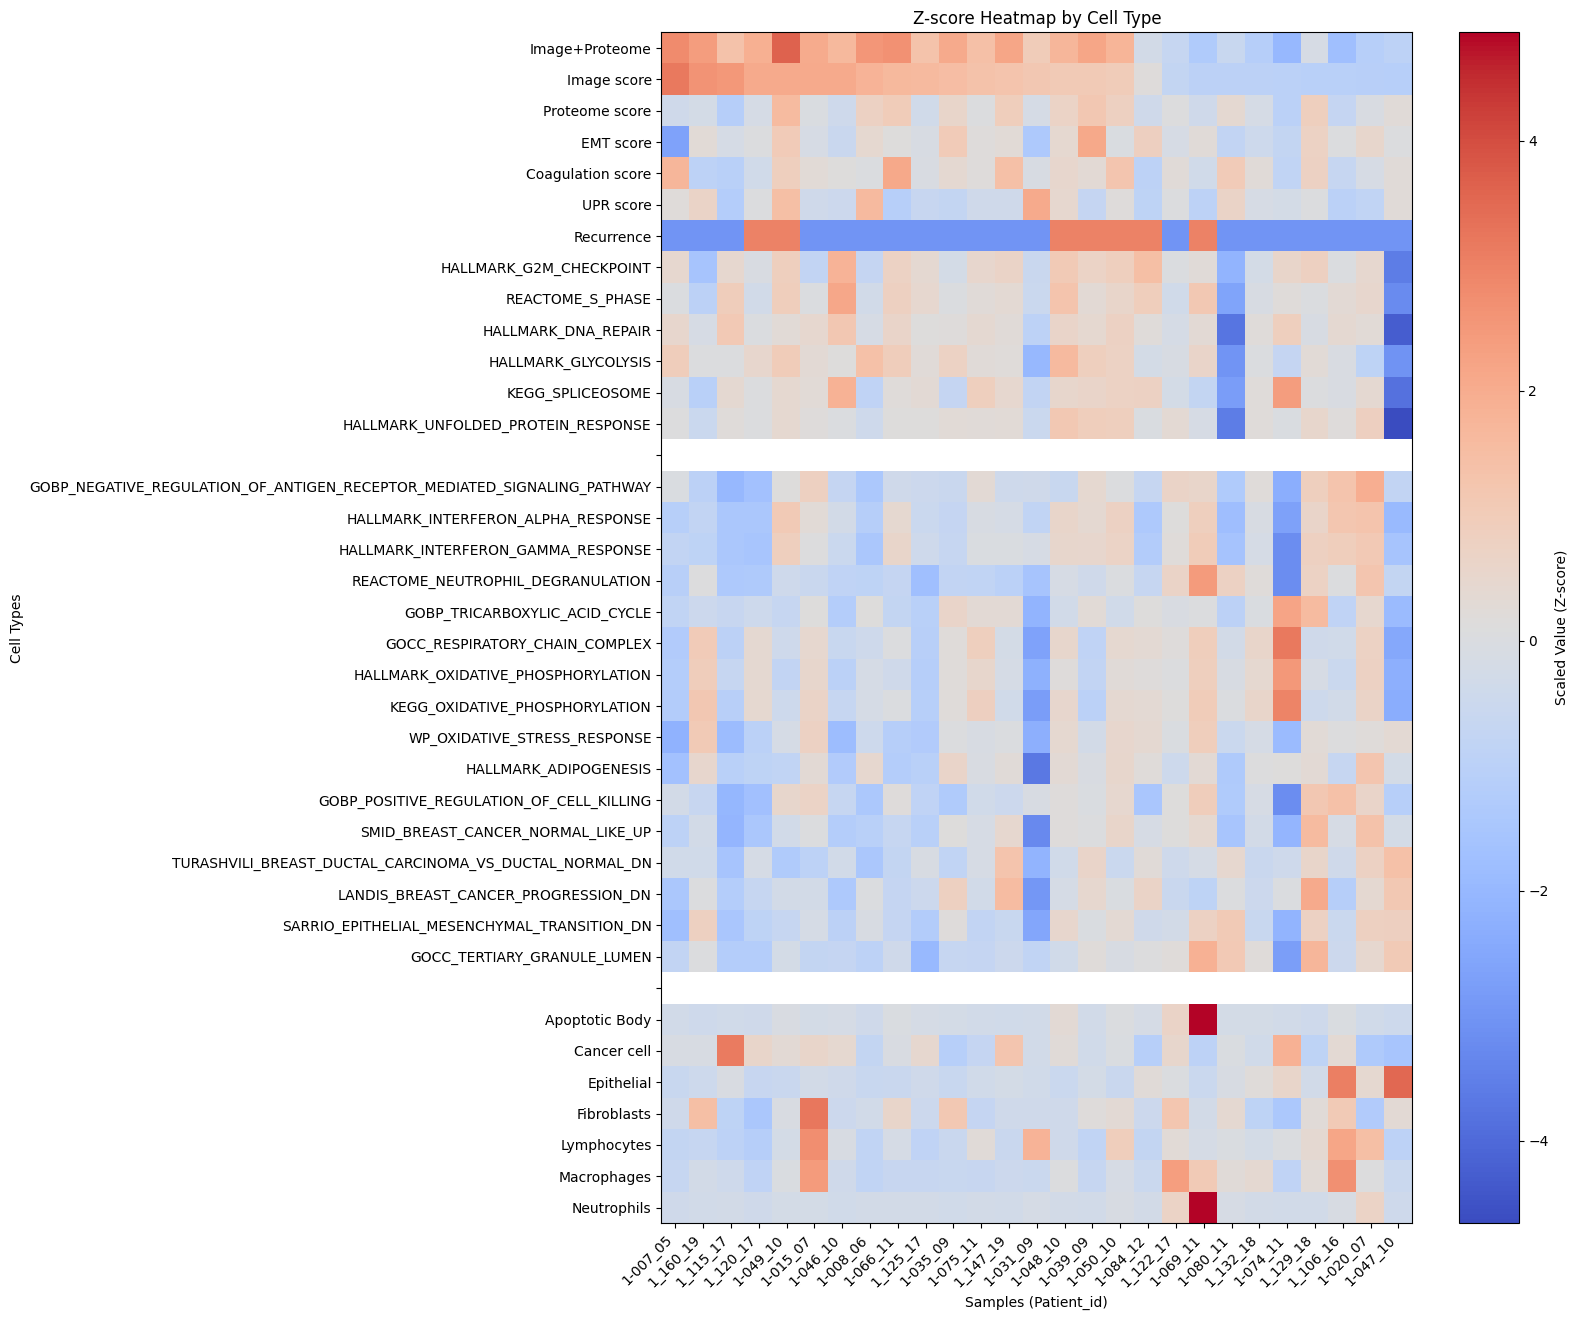

In [23]:
mat = heatmap.copy().drop(columns='Sample_id').set_index('Patient_id').rename(columns = {'index': "  ", 'Unnamed: 15': "  "})
mat = mat.apply(pd.to_numeric, errors='coerce')
# 전치해서: x축 = Sample(Patient), y축 = Cell Type
plt.figure(figsize=(max(8, mat.shape[0]*0.6), max(4, mat.shape[1]*0.35)))

im = plt.imshow(mat.T, aspect='auto', cmap='coolwarm')

plt.colorbar(im, label='Scaled Value (Z-score)')
plt.xticks(np.arange(mat.shape[0]), mat.index, rotation=45, ha='right')
plt.yticks(np.arange(mat.shape[1]), mat.columns)
plt.xlabel("Samples (Patient_id)")
plt.ylabel("Cell Types")
plt.title("Z-score Heatmap by Cell Type")

plt.tight_layout()
plt.show()


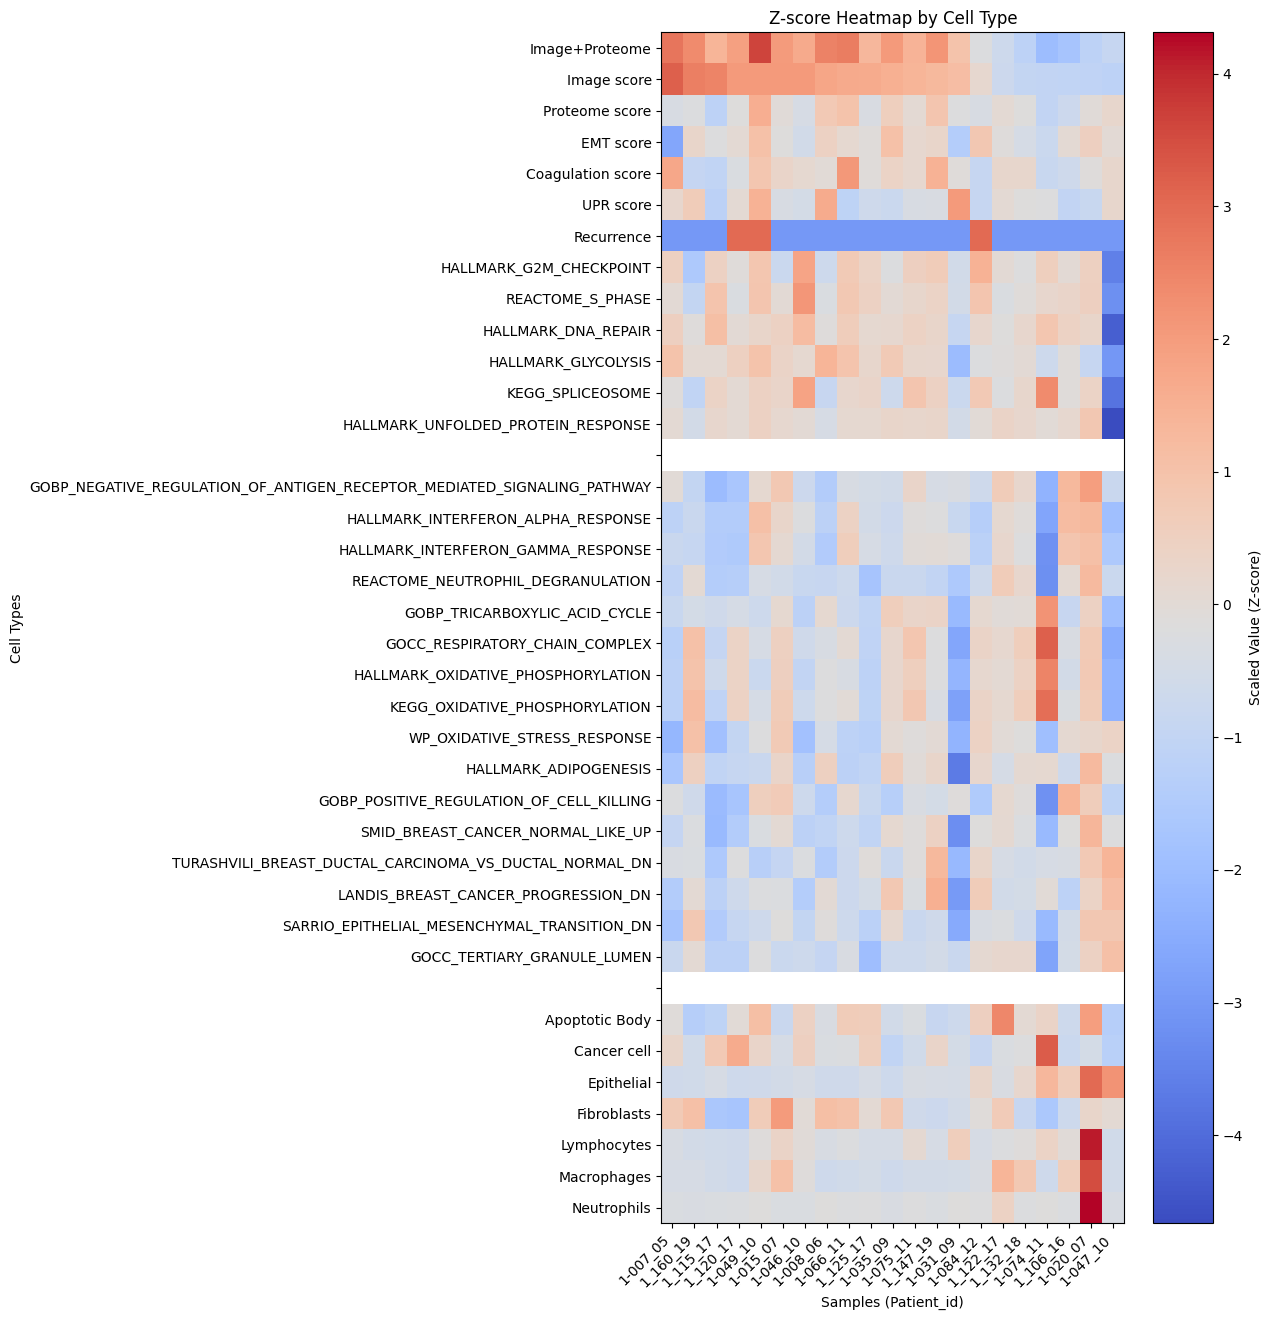

In [17]:
mat = heatmap.copy().drop(columns='Sample_id').set_index('Patient_id').rename(columns = {'index': "  ", 'Unnamed: 15': "  "})
mat = mat.apply(pd.to_numeric, errors='coerce')
# 전치해서: x축 = Sample(Patient), y축 = Cell Type
plt.figure(figsize=(max(8, mat.shape[0]*0.6), max(4, mat.shape[1]*0.35)))

im = plt.imshow(mat.T, aspect='auto', cmap='coolwarm')

plt.colorbar(im, label='Scaled Value (Z-score)')
plt.xticks(np.arange(mat.shape[0]), mat.index, rotation=45, ha='right')
plt.yticks(np.arange(mat.shape[1]), mat.columns)
plt.xlabel("Samples (Patient_id)")
plt.ylabel("Cell Types")
plt.title("Z-score Heatmap by Cell Type")

plt.tight_layout()
plt.show()


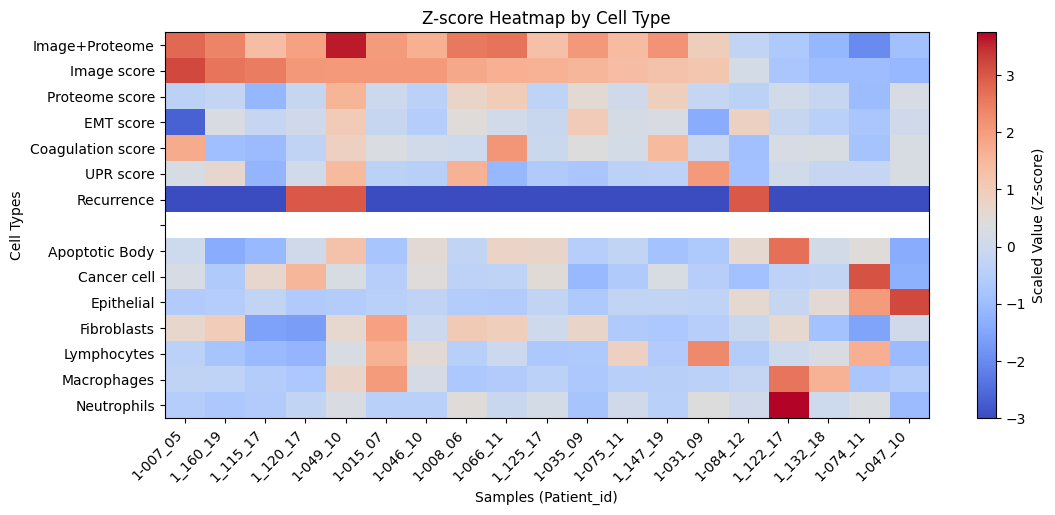

In [138]:
mat = heatmap.copy().drop(columns='Sample_id').set_index('Patient_id').rename(columns = {'index': "  "})
mat = mat.apply(pd.to_numeric, errors='coerce')
# 전치해서: x축 = Sample(Patient), y축 = Cell Type
plt.figure(figsize=(max(8, mat.shape[0]*0.6), max(4, mat.shape[1]*0.35)))

im = plt.imshow(mat.T, aspect='auto', cmap='coolwarm')

plt.colorbar(im, label='Scaled Value (Z-score)')
plt.xticks(np.arange(mat.shape[0]), mat.index, rotation=45, ha='right')
plt.yticks(np.arange(mat.shape[1]), mat.columns)
plt.xlabel("Samples (Patient_id)")
plt.ylabel("Cell Types")
plt.title("Z-score Heatmap by Cell Type")

plt.tight_layout()
plt.show()
